# Análise das Metabases

In [12]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import openml


In [13]:
METABASE_PATH = '../../scripts/metabase/'

## Análise de Bases

In [14]:
dataset_ids = !cat ../../scripts/selected_dataset_ids.txt

In [15]:
len(dataset_ids)

100

In [16]:
openml_datasets = openml.datasets.list_datasets(output_format='dataframe')

In [17]:
selected_datasets = openml_datasets.loc[[int(did) for did in dataset_ids]]

In [18]:
selected_datasets.describe()

,did,version,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
count,100.000000,100.000000,100.000000,42.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.0,100.00000,100.000000
mean,30204.540000,1.980000,1412.960000,5.119048,908.180000,2.190000,38.750000,2408.370000,0.0,0.0,31.79000,6.940000
std,20206.971325,1.874766,1257.287379,8.950276,1068.217635,0.614554,49.739194,2156.095061,0.0,0.0,49.29714,13.863563
min,31.000000,1.000000,150.000000,2.000000,9.000000,2.000000,4.000000,303.000000,0.0,0.0,0.00000,1.000000
25%,1353.000000,1.000000,562.250000,2.000000,236.000000,2.000000,11.000000,1000.000000,0.0,0.0,6.00000,1.000000
50%,44106.500000,1.000000,1000.000000,2.000000,571.000000,2.000000,23.500000,2000.000000,0.0,0.0,16.50000,1.000000
75%,44492.750000,2.000000,1670.500000,3.000000,1000.000000,2.000000,48.250000,2437.750000,0.0,0.0,37.00000,5.000000
max,45711.000000,13.000000,5649.000000,43.000000,5000.000000,5.000000,420.000000,10000.000000,0.0,0.0,419.00000,95.000000


<Axes: title={'center': 'Número de classes'}, ylabel='Frequency'>

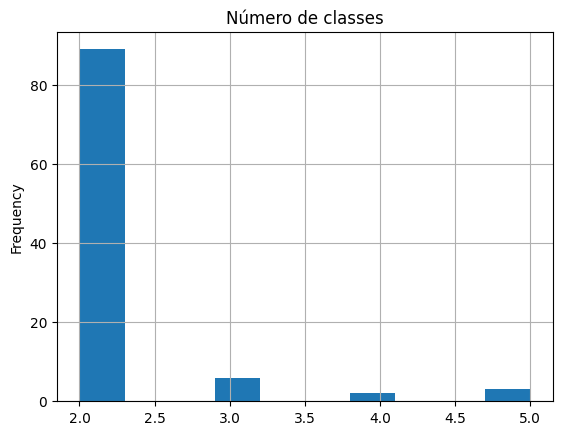

In [19]:
selected_datasets.NumberOfClasses.plot(kind='hist', grid=True, title='Número de classes')

## Análise de Rótulos

In [20]:
def gen_metabase(metabase_files):
    
    df_list= [pd.read_csv(f) for f in metabase_files]
    metabase = pd.concat(df_list, join='inner')
    metabase.dataset_id = metabase.dataset_id.astype(int)

    return metabase
    

In [21]:
def gen_heatmap(metabase, title):

    heatmap = dict()
    
    for k, group in metabase.groupby('dataset_id'):
        heatmap[k] = group.best_strategy
        
    df = pd.DataFrame(heatmap)
    df.fillna('NaN', inplace=True)
    
    value_to_int = {j:i for i, j in enumerate(sorted(pd.unique(df.values.ravel()),reverse=True))}
    cmap = sns.color_palette(n_colors=len(value_to_int))
    
    fig, ax = plt.subplots(figsize=(20,20))  
    sns.heatmap(df.replace(value_to_int).T, cmap=cmap, linewidth=.1, ax=ax)
    
    colorbar = ax.collections[0].colorbar 
    n = len(value_to_int)
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
    colorbar.set_ticklabels(list(value_to_int.keys()))
    
    ax.set_title(title)

In [30]:
def counts_per_dataset(metabase):
    
    heatmap = dict()
    for k, group in metabase.groupby('dataset_id'):
        heatmap[k] = group.best_strategy

    df = pd.DataFrame(heatmap)
    df.fillna('NaN', inplace=True)
    
    counts_df = df.apply(pd.value_counts)
    counts_df = counts_df.fillna(0).transform(lambda x: x.div(sum(x))).T

    return counts_df

### Naive Bayes

In [26]:
nb_files = !find $METABASE_PATH -type f  | grep GaussianNB
len(nb_files)

100

In [28]:
nb_metabase = gen_metabase(nb_files)
print(nb_metabase.shape, len(nb_metabase.groupby('dataset_id')), 'bases')

(10000, 185) 100 bases


In [32]:
counts_per_dataset(nb_metabase).describe()

,density_weighted_sampling,expected_error_reduction,margin_sampling,training_utility_sampling
count,100.000000,100.000000,100.000000,100.000000
mean,0.332400,0.148900,0.305900,0.212800
std,0.224113,0.143878,0.195717,0.231246
min,0.000000,0.000000,0.000000,0.000000
25%,0.160000,0.040000,0.185000,0.077500
50%,0.295000,0.125000,0.310000,0.140000
75%,0.452500,0.212500,0.402500,0.250000
max,0.850000,0.760000,0.860000,1.000000


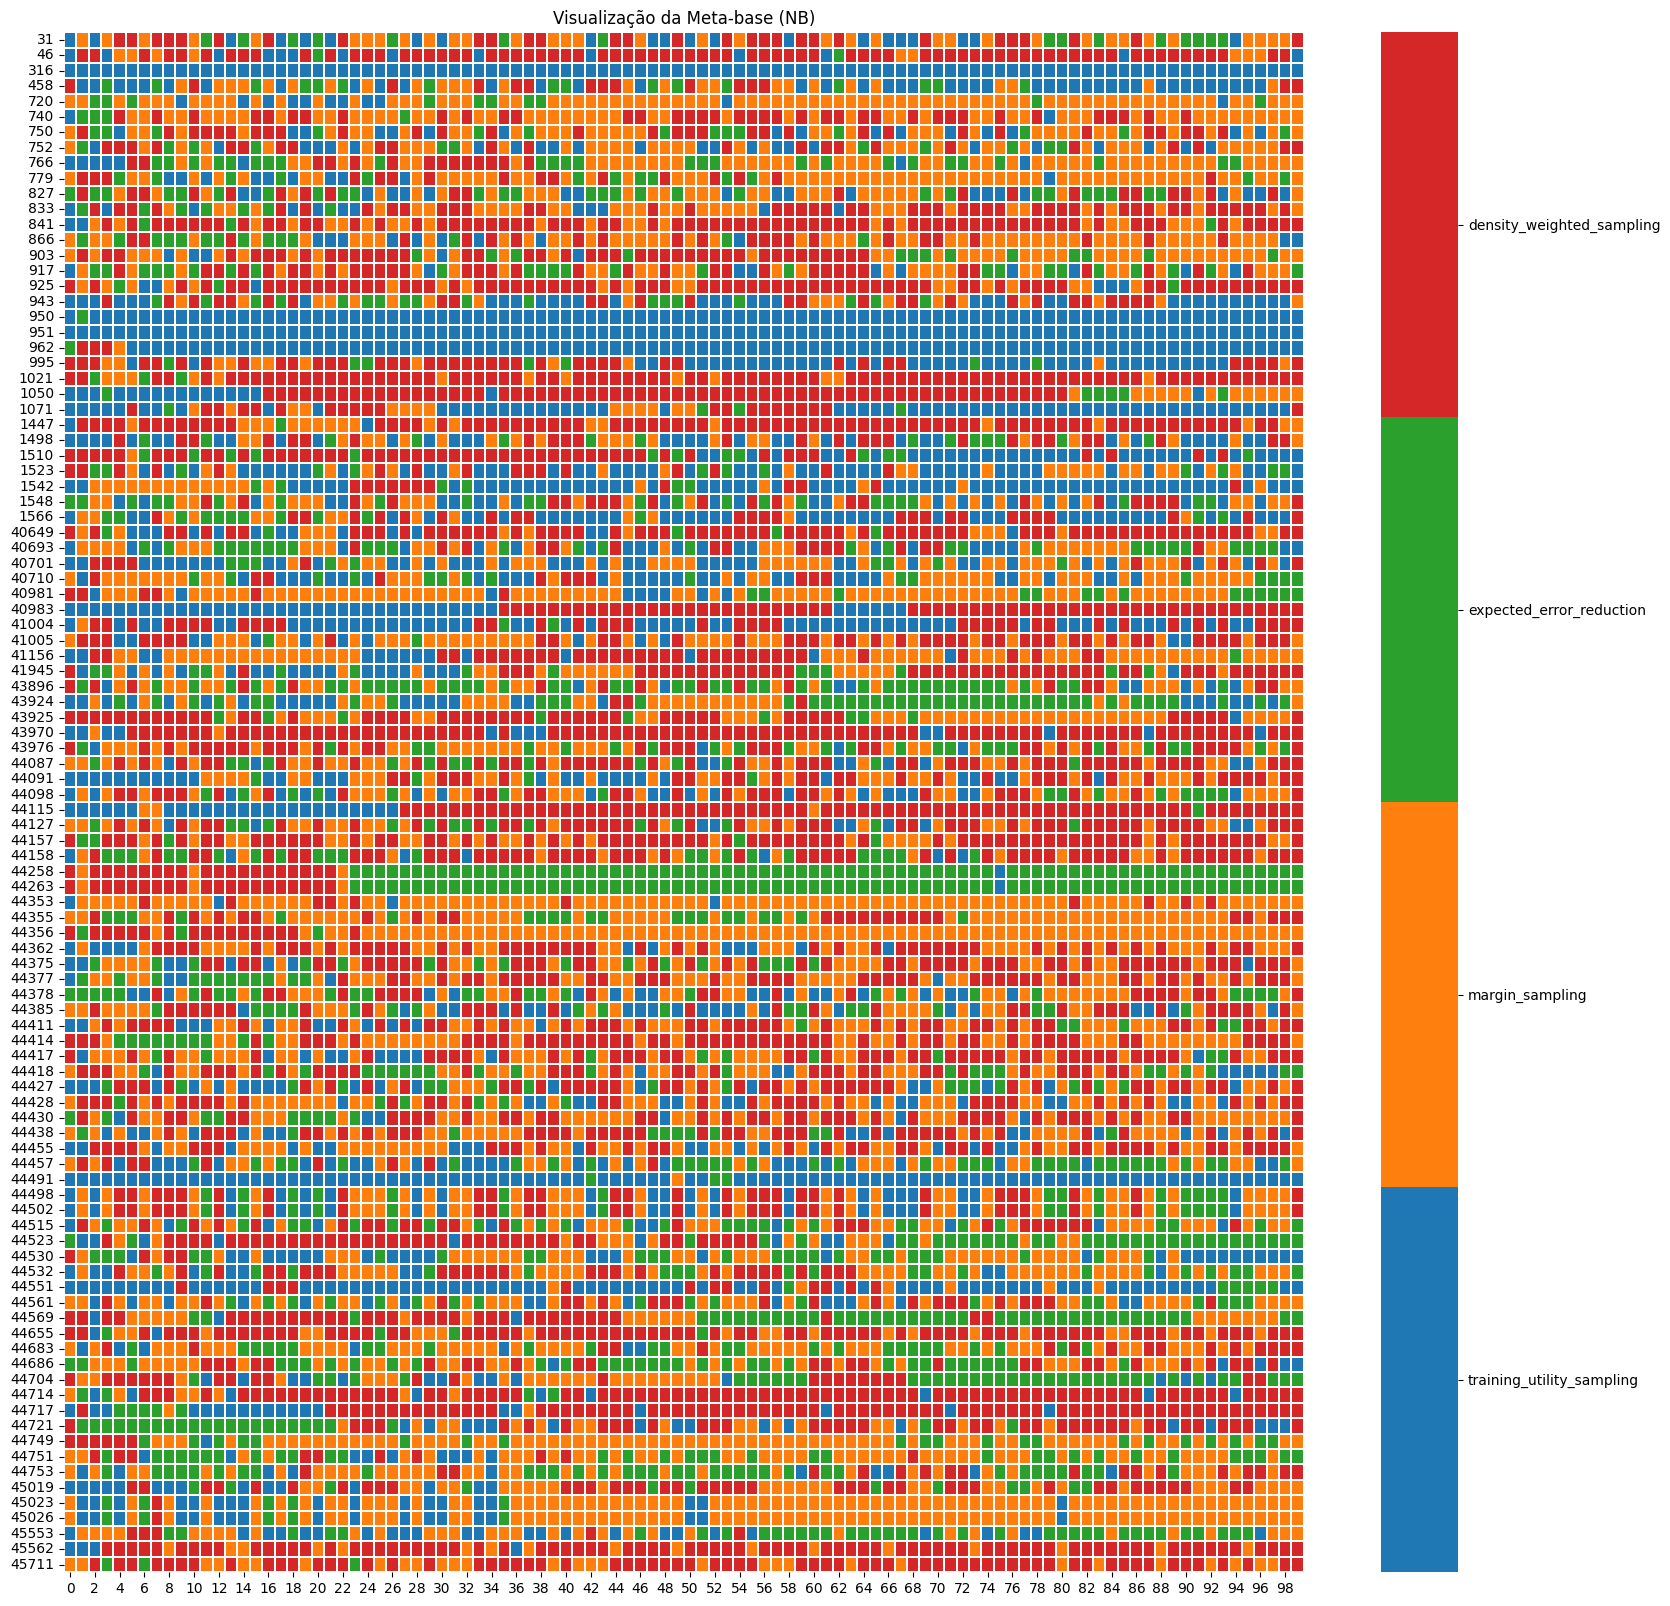

In [34]:
gen_heatmap(nb_metabase, 'Visualização da Meta-base (NB)')

In [35]:
nb_metabase[['best_strategy']].apply(pd.value_counts).transform(lambda x: x.div(sum(x)))

,best_strategy
best_strategy,
density_weighted_sampling,0.3324
margin_sampling,0.3059
training_utility_sampling,0.2128
expected_error_reduction,0.1489


In [25]:
svm_files = !find $METABASE_PATH -type f | grep 'SVC\.csv'

In [26]:
svm_metabase = gen_metabase(svm_files)

In [27]:
svm_metabase.shape

(7810, 76)

In [28]:
counts_per_dataset(svm_metabase).describe()

,consensus_entropy_sampling,entropy_sampling,margin_sampling,max_disagreement_sampling,uncertainty_batch_sampling,uncertainty_sampling,vote_entropy_sampling
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.100993,0.079883,0.095713,0.240803,0.078393,0.300038,0.104176
std,0.084289,0.075263,0.082801,0.211729,0.073862,0.280639,0.084317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.030000,0.010000,0.030000,0.098810,0.010000,0.120000,0.042609
50%,0.082169,0.067816,0.083478,0.170000,0.066667,0.195000,0.092619
75%,0.160000,0.130109,0.142857,0.330743,0.130000,0.389167,0.150000
max,0.333333,0.290000,0.428571,0.950000,0.420000,1.000000,0.360000


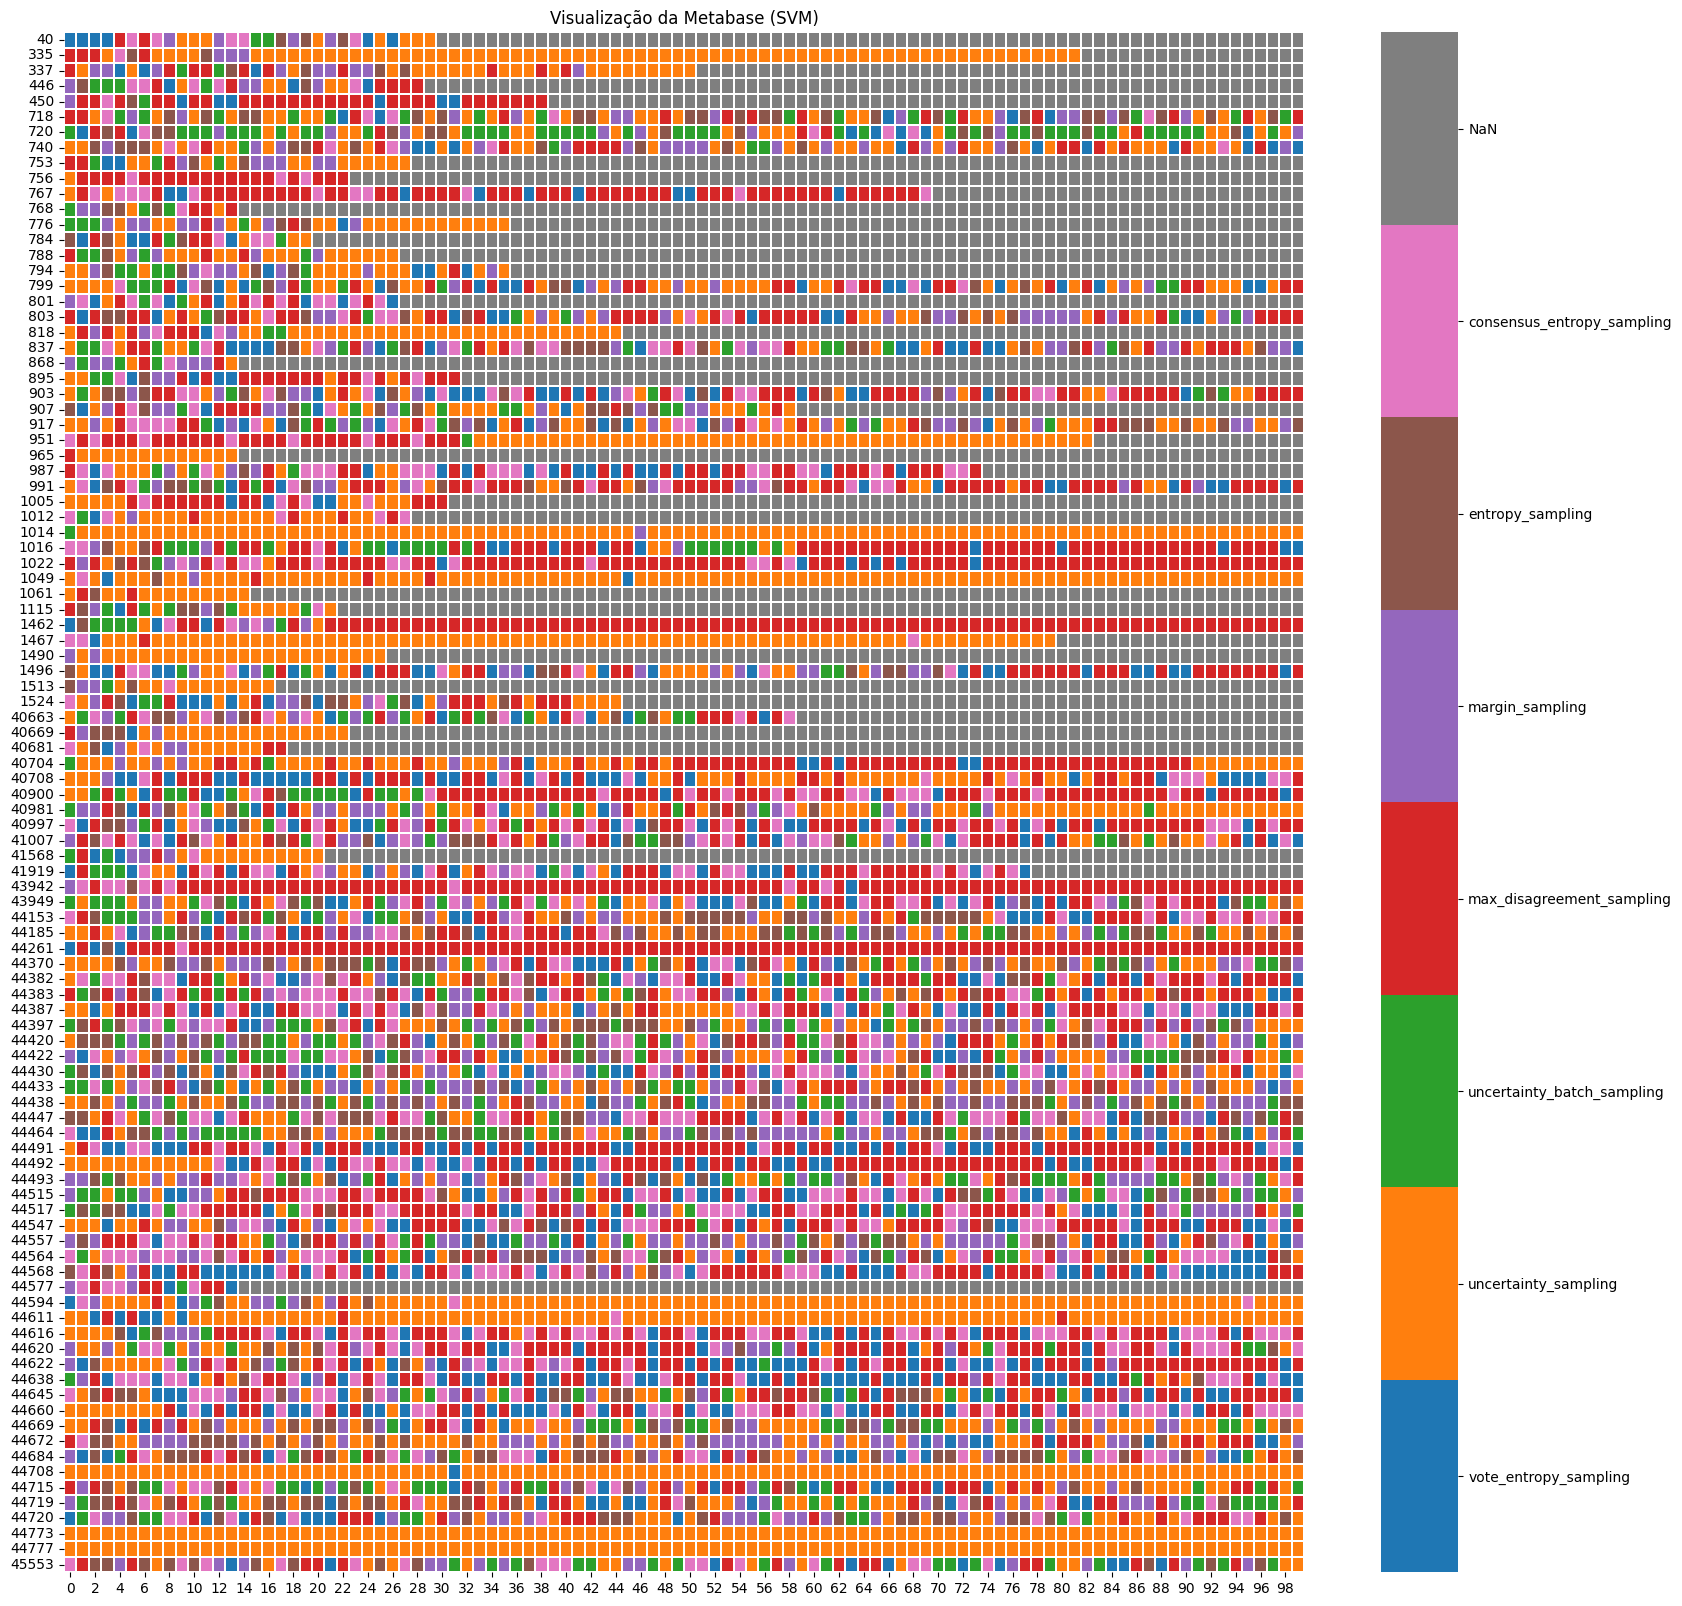

In [29]:
gen_heatmap(svm_metabase, 'Visualização da Metabase (SVM)')

In [30]:
svm_metabase[['best_strategy']].apply(pd.value_counts).transform(lambda x: x.div(sum(x)))

,best_strategy
best_strategy,
uncertainty_sampling,0.274520
max_disagreement_sampling,0.251472
vote_entropy_sampling,0.112292
consensus_entropy_sampling,0.104609
margin_sampling,0.092958
entropy_sampling,0.085403
uncertainty_batch_sampling,0.078745


In [31]:
rf_files = !find $METABASE_PATH -type f | grep 'RandomForestClassifier\.csv'

In [32]:
rf_metabase = gen_metabase(rf_files)
rf_metabase.shape

(7810, 76)

In [33]:
counts_per_dataset(rf_metabase).describe()

,consensus_entropy_sampling,entropy_sampling,margin_sampling,max_disagreement_sampling,uncertainty_batch_sampling,uncertainty_sampling,vote_entropy_sampling
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.088121,0.125382,0.147785,0.110556,0.106064,0.325128,0.096964
std,0.057754,0.063575,0.072260,0.062582,0.057191,0.254185,0.058354
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.060000,0.000000
25%,0.043323,0.083736,0.110833,0.071071,0.071071,0.165000,0.059706
50%,0.089444,0.140000,0.150000,0.110000,0.110556,0.207564,0.090000
75%,0.130000,0.170000,0.195833,0.150000,0.142500,0.371154,0.137273
max,0.285714,0.240000,0.333333,0.282051,0.225806,0.987952,0.238095


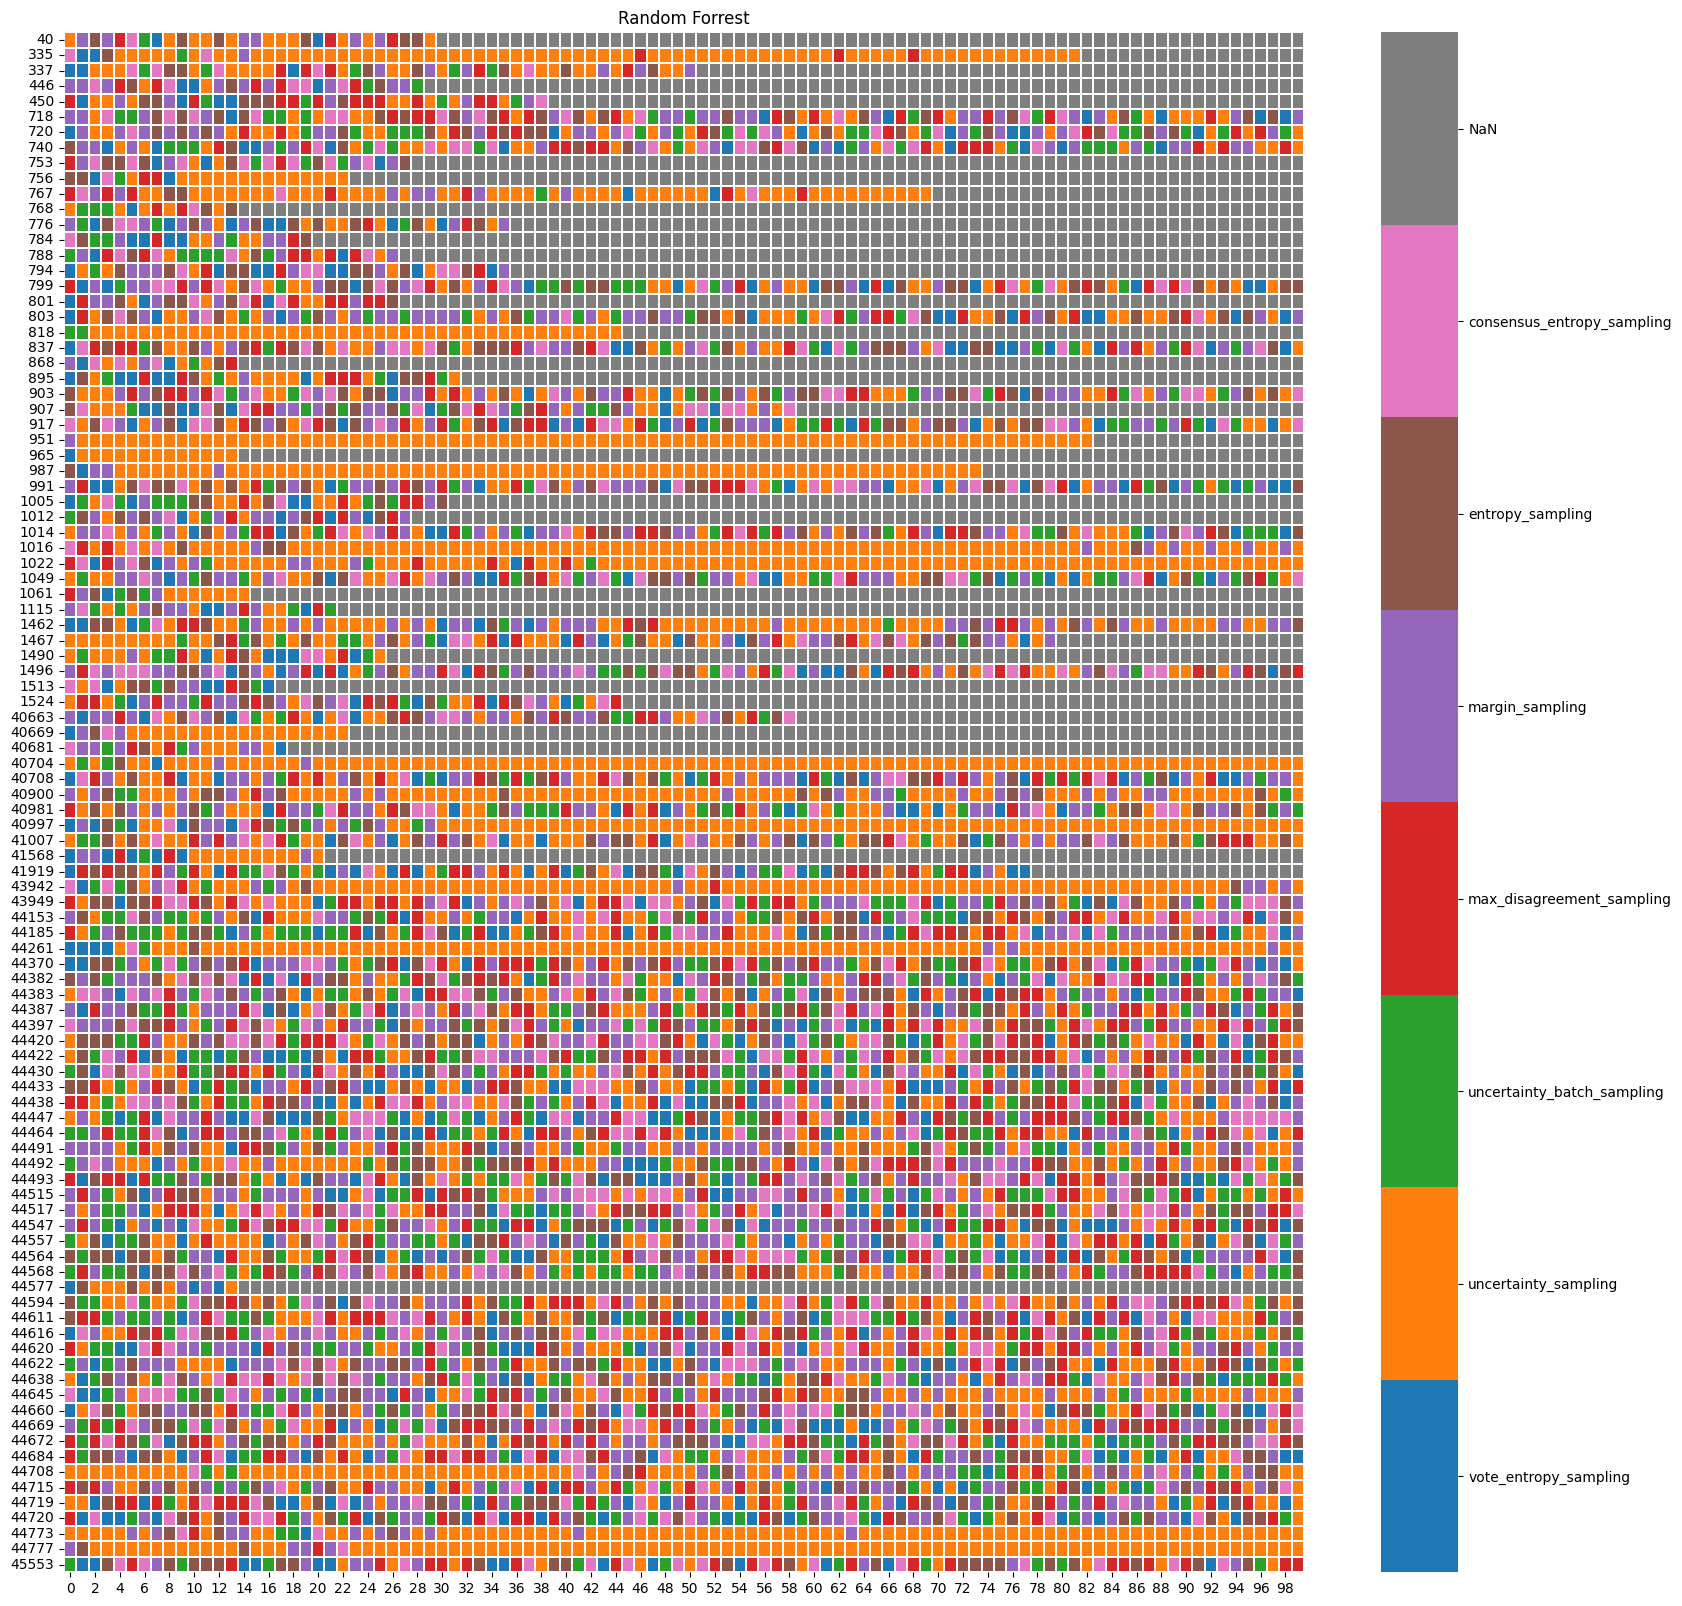

In [34]:
gen_heatmap(rf_metabase, 'Random Forrest')

In [35]:
rf_metabase[['best_strategy']].apply(pd.value_counts).transform(lambda x: x.div(sum(x)))

,best_strategy
best_strategy,
uncertainty_sampling,0.317286
margin_sampling,0.150704
entropy_sampling,0.127657
max_disagreement_sampling,0.112420
uncertainty_batch_sampling,0.109987
consensus_entropy_sampling,0.092190
vote_entropy_sampling,0.089757
